In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
%matplotlib inline
import cv2
import tensorflow as tf
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications import MobileNetV2
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

In [ ]:
# # Creating Train / Test folders (One time use)
root_dir = '/content/drive/MyDrive/COVID19/'
classes_dir = ['COVID','non-COVID']

test_ratio = 0.2

for cls in classes_dir:
    os.makedirs(root_dir +'train/' + cls)
    os.makedirs(root_dir +'test/' + cls)    

    src = root_dir + cls 

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, test_FileNames = np.split(np.array(allFileNames),[int(len(allFileNames)* (1 - test_ratio))])

    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Testing: ', len(test_FileNames))

    for name in train_FileNames:
        shutil.copy(name, root_dir +'train/' + cls)

    for name in test_FileNames:
        shutil.copy(name, root_dir +'test/' + cls)

Total images:  1252
Training:  1001
Testing:  251
Total images:  1229
Training:  983
Testing:  246


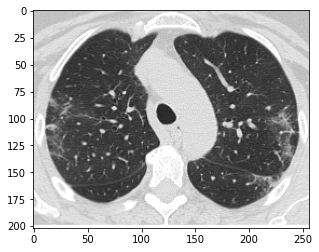

In [ ]:
# Covid 19 patients lungs sample
img = cv2.imread('/content/drive/MyDrive/COVID19/COVID/Covid (1).png')
plt.imshow(img)

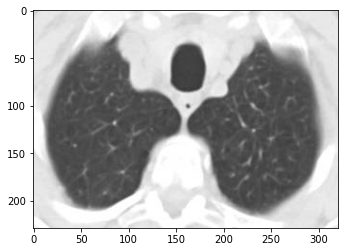

In [ ]:
# Normal lungs sample
img = cv2.imread('/content/drive/MyDrive/COVID19/non-COVID/Non-Covid (1).png')
plt.imshow(img)

In [ ]:
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/COVID19/train'
valid_path = '/content/drive/MyDrive/COVID19/test'

In [ ]:
# add preprocessing layer to the front of VGG
mobilenet = MobileNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in mobilenet.layers:
  layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
# Building Model
x = Flatten()(mobilenet.output)
x = Dense(1000, activation='relu')(x)
x = Dense(32, activation='relu')(x)
prediction = Dense(2, activation='softmax')(x)

model = Model(inputs=mobilenet.input, outputs=prediction)

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

# model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
# data augmentation
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/COVID19/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/COVID19/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1984 images belonging to 2 classes.
Found 497 images belonging to 2 classes.


In [ ]:
#training model
r=model.fit(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/5
62/62 [==============================] - 624s 10s/step - loss: 4.7363 - accuracy: 0.6946 - val_loss: 0.2596 - val_accuracy: 0.8994
Epoch 2/5
62/62 [==============================] - 31s 499ms/step - loss: 0.2402 - accuracy: 0.8913 - val_loss: 0.3348 - val_accuracy: 0.8672
Epoch 3/5
62/62 [==============================] - 31s 497ms/step - loss: 0.1447 - accuracy: 0.9389 - val_loss: 0.1604 - val_accuracy: 0.9356
Epoch 4/5
62/62 [==============================] - 31s 497ms/step - loss: 0.1457 - accuracy: 0.9439 - val_loss: 0.1425 - val_accuracy: 0.9416
Epoch 5/5
62/62 [==============================] - 31s 497ms/step - loss: 0.1143 - accuracy: 0.9586 - val_loss: 0.2638 - val_accuracy: 0.8913


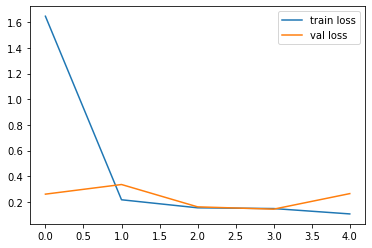

<Figure size 432x288 with 0 Axes>

In [ ]:
# loss plot
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

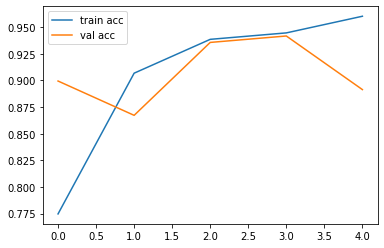

<Figure size 432x288 with 0 Axes>

In [ ]:
# accuracy model
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
#evaluating model using testset
model.evaluate(test_set)

16/16 [==============================] - 3s 178ms/step - loss: 0.2638 - accuracy: 0.8913


[0.26382383704185486, 0.8913480639457703]

In [ ]:
pip install tensorflow-model-optimization

     |████████████████████████████████| 174kB 8.3MB/s 


In [ ]:
import tensorflow_model_optimization as tfmot
model_for_export = tfmot.sparsity.keras.strip_pruning(model)
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()
open("covid19q.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpkp2msjwe/assets


129968816